In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

#Cluster
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from scipy import stats

from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings('ignore')

In [3]:
v_spec = pd.read_csv('vehicle_spec')
v_spec.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
v = v_spec.drop([14,47]).reset_index(drop=True)
v

,Brand,Model,Battery,0 - 100,Top Speed,Range,Efficiency,Fastcharge,Price(German)
0,Nissan,Leaf,37.0,7.9,144,225,164,230.0,29990.0
1,Porsche,Taycan Turbo S,83.7,2.8,260,390,215,860.0,186336.0
2,Nissan,e-NV200 Evalia,37.0,14.0,123,170,218,170.0,43730.0
3,Nissan,Leaf e+,56.0,7.3,157,325,172,390.0,37550.0
4,BMW,i3 120 Ah,37.9,7.3,150,235,161,270.0,39000.0
...,...,...,...,...,...,...,...,...,...
165,Peugeot,e-208,45.0,8.1,150,285,158,460.0,31950.0
166,Peugeot,e-2008 SUV,45.0,8.5,150,255,176,410.0,35450.0
167,Opel,Corsa-e,45.0,8.1,150,285,158,460.0,29900.0
168,Opel,Mokka-e,45.0,9.2,150,255,176,410.0,34110.0


In [25]:
x = StandardScaler().fit_transform(v.iloc[:,2:])

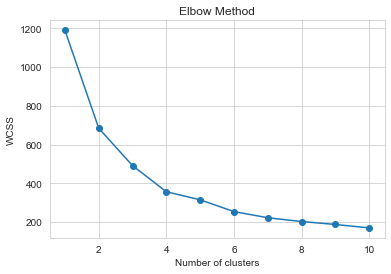

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #Within Cluster Sum of Square - Distance between Centroid and Datapoints 
plt.show()

#Range of Inertia (y-axis) is very large - close to 0 inertia is considered good cluster

Using all the features results in very high Inertia_, reason for high Inertia:
* Inertia is the main objective of Kmeans clustering: Miminzing the distance between data points and the centroid
* Inertia is also performing poorly to a Elongated or irregular shape clusters
* Curse of Dimensionality, Too many features -> Higher Dimensions -> Euclidean Distance get inflated

## Dimensionality Reduction - PCA

Text(0, 0.5, 'cumulative explained variance')

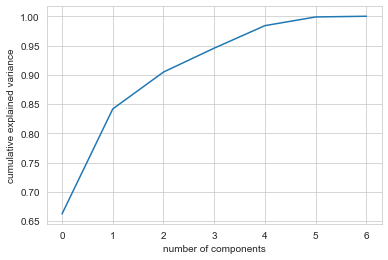

In [27]:
# Dimensionality Reduction using Principal Component Analysis
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Here, the first pca component explains about 85% of the entire dataset
<br>
2 pca components are good fit - > to retain 90% variance 

<b>PCA works by NOT Eliminating Features but instead retain all the features to create a brand new variable
   that can provide most of the variance (information) about the data -> Is is not Feature Selection (Not selecting certain columns from the dataset - Ex. Select Battery, Range.. etc.) but it is Feature Extraction

In [28]:
#Using Kmeans-PCA clustering Technique 
pca = PCA(n_components=2)
principal = pca.fit_transform(x)

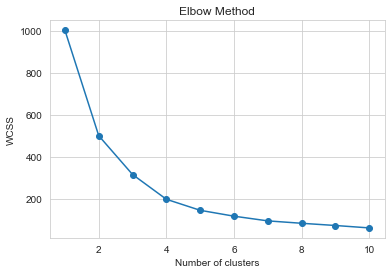

In [29]:
# Using PCA components (2) - Dimension is now 2, to check the inertia
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principal) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The Scale of y-axis (inertia) is dropped, meaning that Dimensionality reduction lead to better clustering accuracy

In [33]:
pca_i = pd.DataFrame(pca.components_.T, index=['Battery','0-100','Top Speed','Range','Efficiency','Fastcharge','Price'],
                     columns=['PC1','PC2'])
pca_i

,PC1,PC2
Battery,0.406097,0.267323
0-100,-0.402679,0.221175
Top Speed,0.432551,0.014260
Range,0.422904,-0.106250
Efficiency,-0.094044,0.853162
Fastcharge,0.401163,-0.088055
Price,0.370420,0.363989


The values Indicate the Correlation of Each Features to the Principal Components
* PC1: 0-100(Decrease when PC1 Increase), Top Speed, Fastcharge
* PC2: Efficiency
<br>
** However, the PC1 has most Variance of the Features Except Efficiency,

## Kmeans - PCA

In [36]:
# Cluster number 3 is chosen - From Elbow Method
# Fitting the Kmenas Algorithm with the Reduced Dimension from PCA (shape is 163, 3 - (Samples, Features))
km_pc = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
km_pc.fit(principal)

KMeans(n_clusters=4, random_state=0)

In [37]:
# Creating a New Dataframe that manifest information about each features along with the Principal Components and Designated Cluster
dl = pd.concat([v.iloc[:,2:], pd.DataFrame(principal, columns=['PC1','PC2'])],axis=1)
dl['Cluster'] = km_pc.labels_
dl['Cluster'] = dl['Cluster'].map({0:'First',1:'Second',2:'Third', 3:'Fourth'})

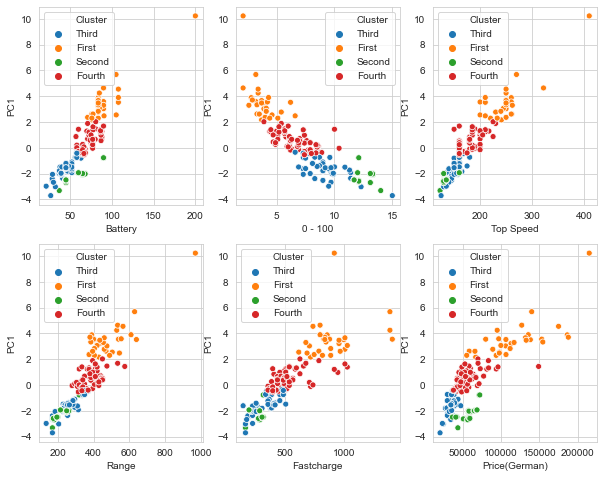

In [38]:
# Correlation of Principal Components with Features, K means Clustered
fig, axes = plt.subplots(2,3,figsize=(10,8))

sns.scatterplot(x=dl['Battery'],y=dl['PC1'],ax=axes[0,0], hue=dl['Cluster'] )
sns.scatterplot(x=dl['0 - 100'],y=dl['PC1'],ax=axes[0,1], hue=dl['Cluster'])
sns.scatterplot(x=dl['Top Speed'],y=dl['PC1'],ax=axes[0,2],hue=dl['Cluster'])
sns.scatterplot(x=dl['Range'],y=dl['PC1'],ax=axes[1,0],hue=dl['Cluster'])
sns.scatterplot(x=dl['Fastcharge'],y=dl['PC1'],ax=axes[1,1],hue=dl['Cluster'])
sns.scatterplot(x=dl['Price(German)'],y=dl['PC1'],ax=axes[1,2],hue=dl['Cluster'])

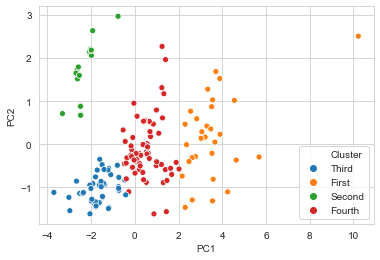

In [39]:
#Plotting 2D Scatter with PC1 and PC2
sns.scatterplot(x=dl['PC1'],y=dl['PC2'],hue=dl['Cluster'])

### Interpretation: There are 3 main types of clusters that provide us the information about the Vehicle types. 
* Low PC1 and PC2 is the one with low Specs
* Low PC1 with high PC2 is the one with Low Specs but having High Efficiency (These Vehicles are likely to be Sold)

* PC1 around 0 (mid Range) are dispersed in terms of Efficiency but more on the low-mid portion, these vehicles are the majority in the market, having Specs that can satisfy the customers and The manufacturers are most likely to produce

* High PC1 tends to have Lower Efficiency compare to others and there aren't many models available in this portion, this means that these vehicles are high-end models. Sports or Luxury Cars, Low PC2 with High PC1 indicates that everything else is very high in specs but the efficiency is low. 

### Gaussian Mixture

Text(0.5, 0, 'n_components')

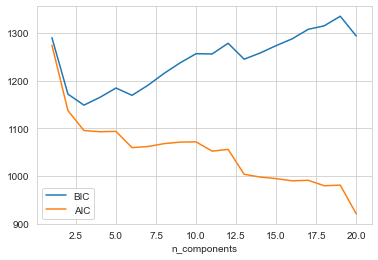

In [40]:
n_components = np.arange(1,21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(principal) for n in n_components]
plt.plot(n_components, [m.bic(principal) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(principal) for m in models], label = 'AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [41]:
gmm = GaussianMixture(n_components=3,random_state=42)
gmm.fit(principal)
pr = gmm.predict(principal)

In [42]:
pca_df = pd.concat([v.iloc[:].reset_index(drop=True), pd.DataFrame(principal, columns=['PC1','PC2'])],axis=1)
pca_df['Gm_Cluster'] = pr
# pca_df.drop(index=[14,47],inplace=True)

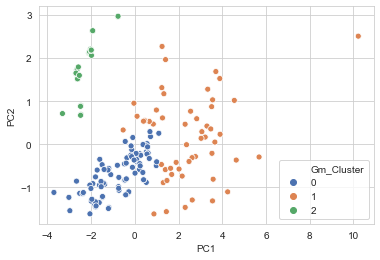

In [43]:
sns.scatterplot(x= pca_df['PC1'],y=pca_df['PC2'], hue= pca_df['Gm_Cluster'] ,data=pca_df, palette='deep')

## DBSCAN

In [58]:
# Setting New Dataframe - PCA components
dbf = dl.iloc[:,7:-1]

In [59]:
dbf.head()

,PC1,PC2
0,-1.994293,-1.317613
1,3.887675,1.526946
2,-3.313765,0.714488
3,-0.746728,-0.981634
4,-1.631201,-1.351793


In [60]:
#Utilizing Nearest Neighbout concept to get the optimal Epsilon
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(dbf)

#Distance: Length to the point
#Indices: Indicies of the nearest points 
distances, indices = nbrs.kneighbors(dbf)  

distances = np.sort(distances, axis=0)
distances = distances[:,1]

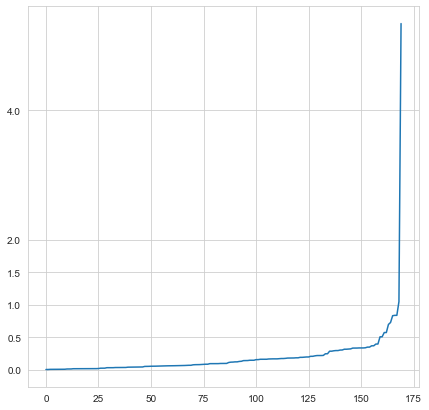

In [61]:
#Plotting the Distance (Distance between datapoints measured)
plt.figure(figsize=(7,7))
plt.yticks([0,0.5,1,1.5,2,4,6,])
plt.plot(distances)

In [68]:
#Epsilon choice is defined at the point of Maximum Curvature
db  = DBSCAN(eps=0.5, min_samples=5).fit(dbf)
labels = db.labels_
dbf['cluster'] = labels

Text(0.5, 0, 'PC1')

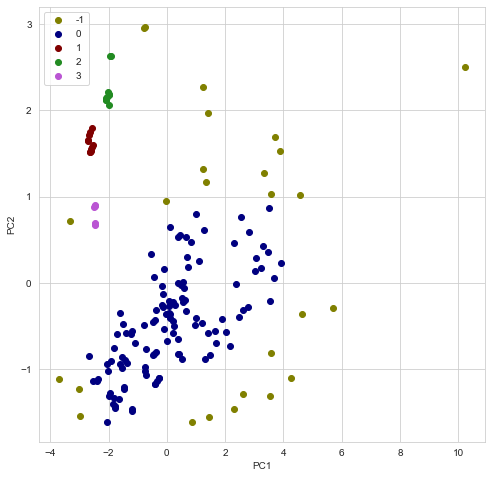

In [69]:
colors = ['navy', 'maroon', 'forestgreen', 'mediumorchid', 'tan','royalblue','olive']

#Plotting PC1 and PC2 and their DB Cluster
fig, ax = plt.subplots(figsize=(8,8))
for g in np.unique(dbf['cluster']):
    ix = np.where(dbf['cluster'] == g)
    ax.scatter(dbf.iloc[ix]['PC1'], dbf.iloc[ix]['PC2'], c = colors[g])
ax.legend(np.unique(dbf['cluster']))
plt.ylabel('PC2')
plt.xlabel('PC1')

### Interpretation:
* The median region is where most of the vehicle resides, Mid-Spec, but other factors such as PC2 (Effiiency) might be different even with other specs being similar
* DBSCAN also identified outliers (-1)
* Cluster 0 are the most frequent one

*Compare to others, DBSCAN extracts the majority from the Middle portion. - Not the Intention of the objective 

## Mean Shift 

In [72]:
msf = dl.iloc[:,7:-1]

In [73]:
# Checking the Bandwidth to define the optimal one
for i in range(1,16):
    ms = MeanShift(bandwidth = i)
    clustering = ms.fit(msf)
    n_cluster = np.unique(clustering.labels_)
    print("Bandwidth {}: {}".format(i, n_cluster))
    

Bandwidth 1: [0 1 2 3 4 5 6 7]
Bandwidth 2: [0 1 2]
Bandwidth 3: [0 1]
Bandwidth 4: [0 1]
Bandwidth 5: [0 1]
Bandwidth 6: [0]
Bandwidth 7: [0]
Bandwidth 8: [0]
Bandwidth 9: [0]
Bandwidth 10: [0]
Bandwidth 11: [0]
Bandwidth 12: [0]
Bandwidth 13: [0]
Bandwidth 14: [0]
Bandwidth 15: [0]


In [74]:
# Using Bandwidth 2 to run the model 
ms = MeanShift(bandwidth = 2,
               seeds=None, 
               bin_seeding=False, 
               min_bin_freq=1, 
               cluster_all=True, 
               n_jobs=None)
clustering = ms.fit(msf)
labels = clustering.labels_
msf['cluster'] = pd.Series(labels)

Text(0, 0.5, 'PC1')

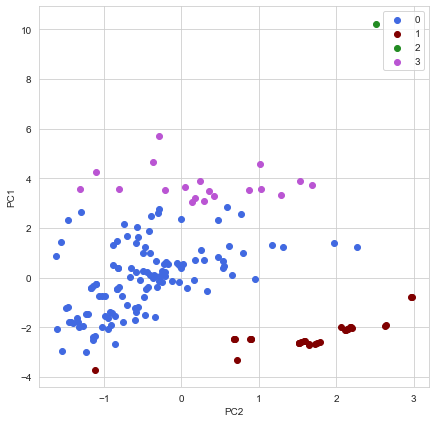

In [76]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']

#Plotting Graph
fig, ax = plt.subplots(figsize=(7,7))
for g in np.unique(msf['cluster']):
    ix = np.where(msf['cluster'] == g)
    ax.scatter(msf.iloc[ix]['PC2'], msf.iloc[ix]['PC1'], c = colors[g])
ax.legend(np.unique(msf['cluster']))
plt.xlabel('PC2')
plt.ylabel('PC1')

### Interpretation:
* It seems like that the Meanshift has clustereed the similar groups into one cluster (the midsection having cluster 0)
* Detected the outliers in other clusters
* Low PC1 has High PC2 (Cluster as 1) 

** As a result, Meanshift is identifying the mid-high spec group as one - Not what we want if we want to cluster specifically
** DBSCAN or Kmeans might work for this data since the objective was to find specific clusters, instead of a large cluster having many datapoints in them

# Conclusion

* For Item Segmentation via clustering, the scope of this work is to identify the specific clusters which can later used to assign each customers based on their input (vehicle specifications) and recommend products that are within the similar range. Looks like Kmean along with PCA (reduced dimensions) resulted in an optimal cluster segmentation. Clustering algorithms such as DBSCAN and Meanshift was not optimal due to its nature of selecting clusters based on the measurement and their method of picking the number of cluster based on their calculation. Kmeans on the other hand uses Elbow method to identify the best cluster number